# Creating a Simulation Domain

In the RIM2D, all imported maps need to be in AAIgrid format (.asc). Furthermore, all files must have the same CRS, transform, shape and no data vlue (-9999). Therefore, a Simulation Domain (SD) is created. All maps are adjusted to the parameters of the SD. In this instance, the SD is created by readjusting a 25 meter DEM which already uses an equal area projection (which is essential because all cells need to have an equal size). 

#### Importing packages

In [41]:
import rasterio
from rasterio import features
from rasterio.transform import from_origin
from rasterio.warp import reproject, Resampling
from rasterio.plot import show
from rasterio.fill import fillnodata
from rasterio.mask import mask
from rasterio.enums import MergeAlg

import geopandas as gpd

import rioxarray

import matplotlib.pyplot as plt
import numpy as np

### Defining the project characteristics

In [2]:
# Defining the borders of the rectangular research simulation domain that encompasses the catchment in the used crs.
N_Border = 3098424
S_Border = 3067456
E_Border = 4047585
W_Border = 4018969

# Setting the resolution for the project (in meters)
PROJ_RES = 8

# Setting a poject crs
PROJ_CRS = {
    'proj': 'laea',
    'lat_0': 52,
    'lon_0': 10,
    'x_0': 4321000,
    'y_0': 3210000,
    'ellps': 'GRS80',
    'units': 'm',
    'no_defs': True
}


# Calculation of the number of rows and columns in the 
PROJ_ROWS = int((N_Border - S_Border) / PROJ_RES)
PROJ_COLS = int((E_Border - W_Border) / PROJ_RES)

# Define the transformation (geotransform) of the raster.
PROJ_TRANSFORM = from_origin(W_Border, 
                                N_Border, 
                                PROJ_RES, 
                                PROJ_RES)

# Currently, data is loaded in 64 bit precision into the model, so using float64 here would provide higher accuracy.
# However, it is proposed to change this to 32 bit precisin to decrease the cmputational load and decrease the required RAM. 
PROJ_DTYPE = np.float32

# No data must always be -9999 for the RIM2D model.
NO_DATA = -9999

#### Settings, establashing directories and file paths

In [50]:
# General pathnames
WD_D = f'D:/Documenten/Studie_Hydrology/Thesis/'
WD_INPUT = f'{WD_D}inputmaps_test_github/'
WD_TEMP = f'{WD_INPUT}temp/'


catchment_path = 'C:/Users/siepb/Documents/Studie_Hydrology/ThesisGeul/Catchment_outline_8m_DEM/Catchment_Outline_8m.shp'
# General settings 
plot_required = True #Set to 'True' or 'False' --> To plot all final results of figures in the jupyer file 


##### Digital Elevation Model (DEM) maps #####
raw_DEM_path = f'{WD_D}Raw_DEM/DEM_HighRes/Working_Folder/Merged_Open_Gaps.tif'
DEM_temp_path = f'{WD_TEMP}DEM_{PROJ_RES}m_res_temp.tif'
DEM_path = f'{WD_INPUT}DEM_{PROJ_RES}m_res.asc'

resamp_type_DEM = Resampling.average



##### Impervious and pervious maps ######
raw_imperv_path = f'{WD_D}Raw_Imperviousness/IMD_2018_010m_be_03035_v020/DATA/IMD_2018_010m_E40N30_03035_v020.tif'
impervious_path = f'{WD_INPUT}Impervious_{PROJ_RES}m_res.asc'

resamp_type_imperv = Resampling.average


##### Landuse to manning coefficients ######
raw_landuse_path = f'{WD_D}Raw_Landuse/Features_selected.shp'

mannings_temp_path = f'{WD_TEMP}Mannings_{PROJ_RES}m_res_temp.asc'
mannings_path = f'{WD_INPUT}Mannings_{PROJ_RES}m_res.asc'


SimDomain_path_8m = 'SimDomain_8m.asc'

# Edited_files
# dem_path = 

pervious_path = f'{WD_INPUT}Pervious_{PROJ_RES}m_res.asc'
sewershed_path = f'{WD_INPUT}Sewershed_Zero_{PROJ_RES}m_res.asc'

sewershed_path = f'{WD_INPUT}Sewershed_{PROJ_RES}m_res.asc'

In [15]:
# Create an array of zeros that will be used as raster.
empty_raster = np.zeros((PROJ_ROWS, PROJ_COLS), 
                        dtype=PROJ_DTYPE)

# Create a raster file of the Simulation Domain
with rasterio.open(f'{WD_INPUT}Sim_Domain.asc', 
                   'w', 
                   driver='AAIGrid', 
                   dtype=PROJ_DTYPE, 
                   width=PROJ_COLS, 
                   height=PROJ_ROWS,
                   crs=PROJ_CRS, 
                   transform=PROJ_TRANSFORM,
                   count=1,
                  nodata = NO_DATA) as dst:
    dst.write(empty_raster, 1)

In [38]:
with rasterio.open(f'{WD_INPUT}Sim_Domain.asc') as proj_outline:
    PROJ_BOUNDS = proj_outline.bounds
    PROJ_SHAPE = proj_outline.shape
print(PROJ_BOUNDS)

BoundingBox(left=4018969.0, bottom=3067456.0, right=4047585.0, top=3098424.0)


# Functions

In [30]:
def Reproject(raw_file, edited_file, resamp_type, plot_required): 
    
    with rasterio.open(raw_file) as ras_raw:
        
        with rasterio.open(edited_file,
                           'w',
                           driver = 'AAIGrid',
                           dtype = PROJ_DTYPE,
                           width = PROJ_COLS,
                           height = PROJ_ROWS,
                           crs = PROJ_CRS,
                           transform = PROJ_TRANSFORM,
                           count = 1,
                           nodata = NO_DATA) as ras_edit:
                                                reproject(source = rasterio.band(ras_raw, 1),
                                                destination = rasterio.band(ras_edit, 1),
                                                src_transform = ras_raw.transform,
                                                src_crs = ras_raw.crs,
                                                dst_transform = PROJ_TRANSFORM,
                                                dst_crs = PROJ_CRS,
                                                resampling = resamp_type,
                                                bounds = PROJ_BOUNDS
                                                )
    if plot_required == True:
        with rasterio.open(edited_file) as ras_plot:
            fig, ax = plt.subplots(1, figsize = (10, 10))
            show(ras_plot, ax = ax)

In [5]:
# should make variable for max search distance

def Fill_gaps(with_gaps, without_gaps):
    with rasterio.open(with_gaps) as src:        
        kwargs = src.profile
        arr = src.read(1)
        
        arr_filled = fillnodata(arr, 
                                mask=src.read_masks(1),
                                max_search_distance = 50, 
                                smoothing_iterations = 0
                               )
        
        kwargs = src.profile
        
    with rasterio.open(without_gaps, 
                       'w',
                      **kwargs) as dest:
        dest.write_band(1, arr_filled)
        
    if plot_required == True:
        with rasterio.open(without_gaps) as ras_plot:
            fig, ax = plt.subplots(1, figsize = (10, 10))
            show(ras_plot, ax = ax)

In [24]:
def Catchment_mask(raster_catchment_input, raster_catchment_output, polygon_catchment):
    
    catchment = gpd.read_file(polygon_catchment)

    buffer_catchment = catchment.buffer(10)
    polygon = buffer_catchment.geometry.values[0]  

    with rasterio.open(raster_catchment_input) as ras:
        out_image, out_transform = mask(dataset = ras,
                                        shapes = [polygon],
                                        all_touched = True,
                                        crop = False,
                                        filled = True,
                                        nodata = NO_DATA
                                       )

        kwargs = ras.profile
    
    with rasterio.open(raster_catchment_output,
                       'w',
                       **kwargs,
#                        DECIMAL_PRECISION = 3
                      ) as dst:
        dst.write(out_image[0,:,:], indexes = 1)
                       
        

### DEM processing

For the Fill_Gapsfunction to work properly, the input file must be be a .tif file in order for the fillnodata function to read the mask layer properly. 

At the end of this script, there is code that uses data from open street map on houses to make locations with houses 'No Data'. This is unedited to be a part of this code so changes must be made befor use.

In [25]:
# First reproject 
Reproject(raw_DEM_path, DEM_temp_path, resamp_type_DEM, plot_required)
Fill_gaps(DEM_temp_path, DEM_temp_path)
Catchment_mask(DEM_temp_path, DEM_path, catchment_path)

### Pervious and impervious datasets

The imperviousness map can be downloaded from Copernicus website (link below). The Imperviousness is given in percentages, whilke the RIM2D model reuquires a fraction (between 0 and 1). Therefore the rastervalues are devided by 100. The Perviousness is the opposite of the imperviousness.

https://land.copernicus.eu/pan-european/high-resolution-layers/imperviousness/status-maps 

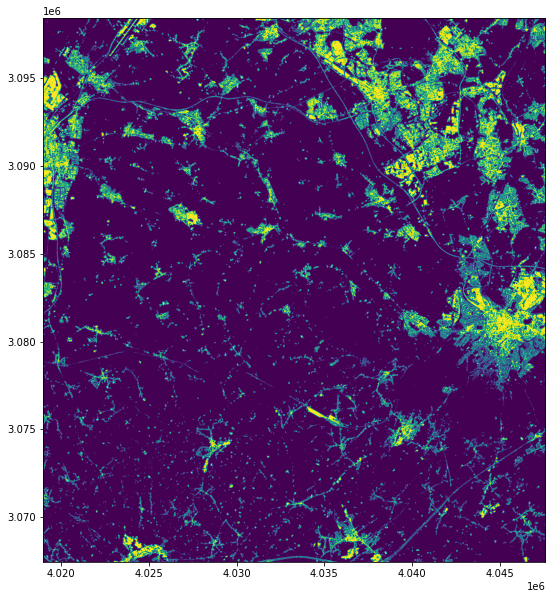

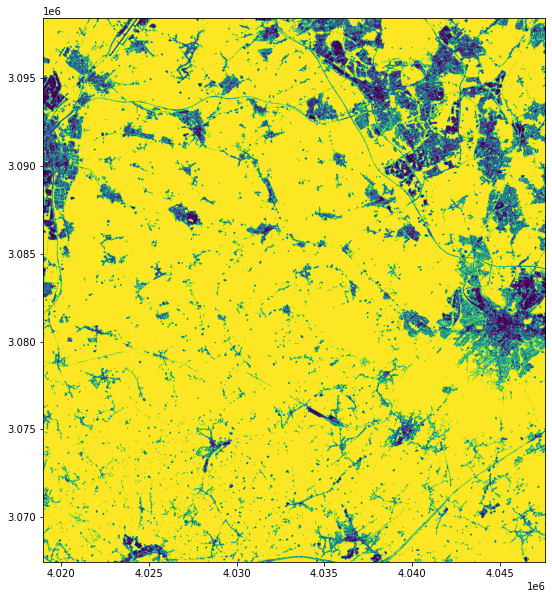

In [29]:
with rasterio.open(raw_imperv_path) as imperv_raw:
    imperv_array = imperv_raw.read(1)

    imperv_array = np.where(imperv_array<101, imperv_array/100, NO_DATA)
    perv_array = 1-imperv_array
    
    kwargs = imperv_raw.meta.copy()
    kwargs.update(dtype = PROJ_DTYPE,
                  nodata = NO_DATA)
    
    with rasterio.open(f'{WD_TEMP}imperv_temp.tif',
                        'w',
                        **kwargs) as dst:
        dst.write(imperv_array, indexes = 1)
                
    with rasterio.open(f'{WD_TEMP}perv_temp.tif',
                       'w',
                       **kwargs) as dst:
        dst.write(perv_array, indexes = 1)


Reproject(f'{WD_TEMP}imperv_temp.tif', f'{WD_TEMP}imperv_temp_2.tif', resamp_type_imperv, plot_required)
Reproject(f'{WD_TEMP}perv_temp.tif', f'{WD_TEMP}perv_temp_2.tif', resamp_type_imperv, plot_required)

Catchment_mask(f'{WD_TEMP}perv_temp_2.tif', pervious_path, catchment_path)
Catchment_mask(f'{WD_TEMP}imperv_temp_2.tif', impervious_path, catchment_path)

## Landuse map to manning coefficients

In [43]:
manning_per_lc = np.array([[111, 0.013],
                           [112, 0.013],
                           [121, 0.013],
                           [122, 0.013],
                           [123, 0.013],
                           [124, 0.013],
                           [131, 0.013],
                           [132, 0.013],
                           [133, 0.013],
                           [141, 0.025],
                           [142, 0.025],
                           [211, 0.03],
                           [212, 0.03],
                           [213, 0.03],
                           [221, 0.08],
                           [222, 0.08],
                           [223, 0.08],
                           [231, 0.035],
                           [241, 0.04],
                           [242, 0.04],
                           [243, 0.05],
                           [244, 0.06],
                           [311, 0.1],
                           [312, 0.1],
                           [313, 0.1],
                           [321, 0.04],
                           [322, 0.05],
                           [323, 0.05],
                           [324, 0.06],
                           [331, 0.025],
                           [332, 0.035],
                           [333, 0.027],
                           [334, 0.025],
                           [335, 0.01],
                           [411, 0.04],
                           [412, 0.04],
                           [421, 0.04],
                           [422, 0.04],
                           [423, 0.04],
                           [511, 0.05],
                           [512, 0.05],
                           [521, 0.07],
                           [522, 0.07],
                           [523, 0.07],])

In [51]:
landuse = gpd.read_file(f'{raw_landuse_path}')

# # Check which types of landuse are prersent in the loaded file 
# values_in_lu = landuse['Code_18'].unique()
# print(values_in_lu.astype(int))

# Changing the identification codes of the land use types to floats and adding to a new column
lu_code = (np.array(landuse['Code_18']))
lu_code = lu_code.astype(np.float32)
landuse['lu_code_int'] = lu_code

geom_value = ((geom,value) for geom, value in zip(landuse.geometry, landuse['lu_code_int']))

landuse_rasterized = features.rasterize(geom_value,
                                out_shape = PROJ_SHAPE,
                                transform = PROJ_TRANSFORM,
                                fill = NO_DATA,                                                            
                                all_touched = False,                  # True: all cells touched by the polygon will be value 1. False: only if large part of the cell is filled by the the polygon it will have value 1.
                                merge_alg = MergeAlg.replace,
                                dtype = np.int16)

for i in range(len(manning_per_lc)):
    landuse_rasterized = np.where(landuse_rasterized == manning_per_lc[i, 0], manning_per_lc[i, 1], landuse_rasterized)

with rasterio.open(
    f'{mannings_temp_path}',
    'w',
    driver= 'AAIGrid',
    dtype = np.float32,
    crs = PROJ_CRS,
    transform = PROJ_TRANSFORM,
    height = PROJ_ROWS,
    width = PROJ_COLS,
    count = 1,
    nodata = NO_DATA) as dst:
    dst.write(landuse_rasterized, indexes = 1)

    
Catchment_mask(mannings_temp_path, mannings_path, catchment_path)

# fig, ax = plt.subplots(1, figsize = (10, 10))
# showing = show(landuse_rasterized, ax = ax)

#### Sewershed full of ones

In [1]:
with rasterio.open(f'{WD_INPUT}Sim_Domain.asc') as grid:
    
    grid_arr = grid.read(1)    
    grid_zeros = grid_arr * 0
    Sewershed = grid_zeros + 1
    
    kwargs = grid.profile
    with rasterio.open(f'{sewershed_path}', 
                       'w', 
                       **kwargs) as dst:
        dst.write(Sewershed, indexes=1)

NameError: name 'rasterio' is not defined

### No data for Buildings in DEM

In [ ]:
# import osmnx as os

# extra_clip = 0.03 # This value makes sure the OSM map is still complete after reprojecting

# osm_data = os.geometries.geometries_from_bbox(N_Border + extra_clip, 
#                                               S_Border - extra_clip, 
#                                               E_Border + extra_clip, 
#                                               W_Border - extra_clip, 
#                                               tags = {'building': True})

# # Changing crs to project crs  
# osm_data = osm_data.to_crs(PROJECT_CRS)

# # Selecting the geometry from the shapefile and rasterizing osm
# geom = [shapes for shapes in osm_data.geometry]
# osm_rasterized = features.rasterize(geom,
#                                 out_shape = PROJECT_SHAPE,     # Maybe if I change shape for width and height like below, I will not need te extra clip? Think about this and try is this might work:)
#                                 fill = 0,                            
#                                 transform = PROJECT_TRANSFORM,
#                                 all_touched = False,                  # True: all cells touched by the polygon will be value 1. False: only if large part of the cell is filled by the the polygon it will have value 1.
#                                 default_value = 1,
#                                 dtype = None)

# with rasterio.open(
#     f'{WD_INPUT}{osm_path}', 
#     'w',
#     driver = 'AAIGrid',
#     dtype = rasterio.uint8,
#     crs = PROJECT_CRS,
#     transform = PROJECT_TRANSFORM,
#     height = PROJECT_HEIGHT,
#     width = PROJECT_WIDTH,
#     count = 1,
#     nodata = NO_DATA) as dst:
#     dst.write(osm_rasterized, indexes = 1)
    
# with rasterio.open(f'{WD_INPUT}{osm_path}') as osm_working:
#     with rasterio.open(f'{WD_INPUT}{dem_path}') as dem_working:
#         osm_array = osm_working.read(1)
#         dem_array = dem_working.read(1)
        
#         dem_array[osm_array == 1] = -9999

#         kwargs = dem_working.profile
        
# with rasterio.open(
#     f'{WD_INPUT}{dem_housesnodata_path}',
#     'w',
#     **kwargs) as dst:
#     dst.write(dem_array, indexes = 1) 

## Archive

In [7]:
# with rasterio.open(dem_25m_path) as dem:
#     print(dem.crs)

# with rioxarray.open_rasterio(dem_25m_path, masked = True, decode_coords='all') as dem:
#     crs = dem.rio.crs
#     print(crs)
    
#     dem = dem.rio.clip_box(
#         minx=W_Border,
#         miny=S_Border,
#         maxx=E_Border,
#         maxy=N_Border,
#         crs = crs)

# dem.rio.to_raster(f'{WD_input}temp/DEM_25m_clipped.asc')

In [7]:
# # The downscale factor is 5 because the used DEM is 25 m and we want to go 8.33 m (25/3 = 8.33)
# downscale_factor = 3

# # Open the source raster file with rasterio
# with rasterio.open(f'{WD_INPUT_25m}{dem_path_25m}') as src:
#     # Resample data to target shape
#     data = src.read(
#         out_shape=(
#             src.count,
#             int(src.height * downscale_factor),
#             int(src.width * downscale_factor)
#         ),
#         resampling=rasterio.enums.Resampling.bilinear
#     )

#     # Scale image transform
#     transform = src.transform * src.transform.scale(
#         (src.width / data.shape[-1]),
#         (src.height / data.shape[-2])
#     )

# # Create the output raster file with rasterio
# with rasterio.open(
#     f'{WD_INPUT_8m}{SimDomain_path_8m}',
#     'w',
#     driver='AAIGrid',
#     dtype='float32',
#     crs=src.crs,
#     transform=transform,
#     height=data.shape[1],
#     width=data.shape[2],
#     count=1,
#     nodata=NO_DATA
# ) as dst:
#     dst.write(data * 0)  # times zero to create an empty grid